In [48]:
from langchain.embeddings import LlamaCppEmbeddings
from langchain.llms import LlamaCpp
from langchain.prompts import PromptTemplate
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.chains import LLMChain

import pandas as pd
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import RBFInterpolator, LinearNDInterpolator
from scipy.stats import pearsonr
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# %matplotlib inline
# from mpl_toolkits.mplot3d import Axes3D

In [ ]:
#Use Llama model for embedding
llama_model_path = '/cis/home/adesilva/ashwin/research/llm-work/llama.cpp/models/7B-chat/ggml-model-q4_0.bin'
embedding_model = LlamaCppEmbeddings(model_path=llama_model_path)

In [ ]:
# Make sure the model path is correct for your system!
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])
llm = LlamaCpp(
    model_path=llama_model_path,
    temperature=0.75,
    max_tokens=500,
    top_p=1,
    callback_manager=callback_manager, 
    verbose=False, # Verbose is required to pass to the callback manager
)

### Experiment 1

In [6]:
filepath = '../data/contexts.xlsx'
df = pd.read_excel(filepath)

prompt = """
    Give a precise answer to the question based on the context. Don't be verbose. The answer should be either a yes or a no.
    CONTEXT: {}
    QUESTION: Was R.A. Fisher a great man?
    ANSWER:
    """
num_reps = 10
k = 50

In [ ]:
embeddings = []
outputs = []
labels = []
for i in range(len(df)):
    context = df['string'][i]
    label = 1 if df['label'][i] == 'statistics' else 0
    labels.append(label)
    updated_prompt = prompt.format(context)
    
    embedding = embedding_model.embed_query(updated_prompt)
    embeddings.append(embedding)
    
    outputs_for_prompt = []
    count = 0
    while count < k:
        out = llm(updated_prompt)
        out = out.replace('.','').lstrip().rstrip().lower()
        if out == "yes" or out == "no":
            outputs_for_prompt.append(out)
            count += 1
    outputs.append(outputs_for_prompt)

labels = np.array(labels)
embeddings = np.array(embeddings)

In [8]:
binary_outputs = np.zeros((len(outputs), num_reps))
for i in range(len(outputs)):
    for j in range(num_reps):
        out = outputs[i][j]
        if out == 'yes':
            binary_outputs[i, j] = 1
        elif out == 'no':
            binary_outputs[i, j] = 0
        else:
            break
p = np.mean(binary_outputs, axis=1)

In [9]:
np.save("1-embeddings.npy", embeddings)
np.save("1-labels.npy", labels)
np.save("1-probabilities.npy", p)
np.save("1-outputs.npy", binary_outputs)

In [43]:
embeddings = np.load("1-embeddings.npy")
binary_outputs = np.load("1-outputs.npy")
labels = np.load("1-labels.npy")
p = np.load("1-probabilities.npy")

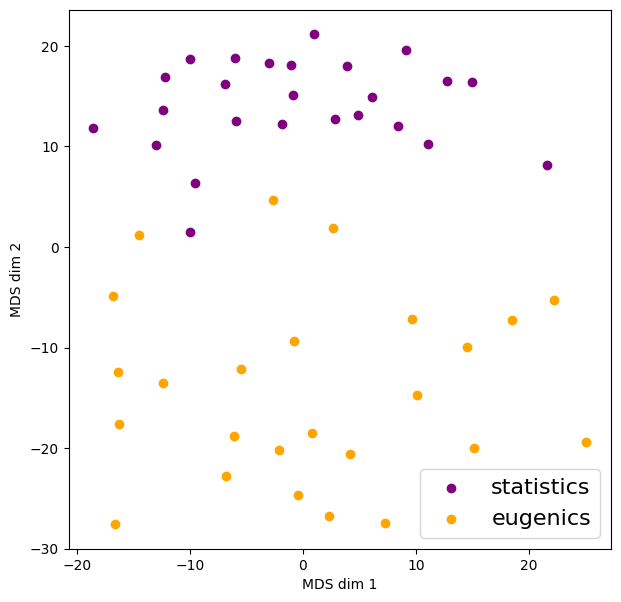

In [44]:
mds = MDS(n_components=2, normalized_stress='auto')
lowdim_embeddings = mds.fit_transform(embeddings)

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(lowdim_embeddings[:, 0][labels == 1], lowdim_embeddings[:, 1][labels == 1], c='purple', label='statistics')
ax.scatter(lowdim_embeddings[:, 0][labels == 0], lowdim_embeddings[:, 1][labels == 0], c='orange', label='eugenics')
ax.set_xlabel("MDS dim 1")
ax.set_ylabel("MDS dim 2")
ax.legend(frameon=True, fontsize=16)
plt.show()

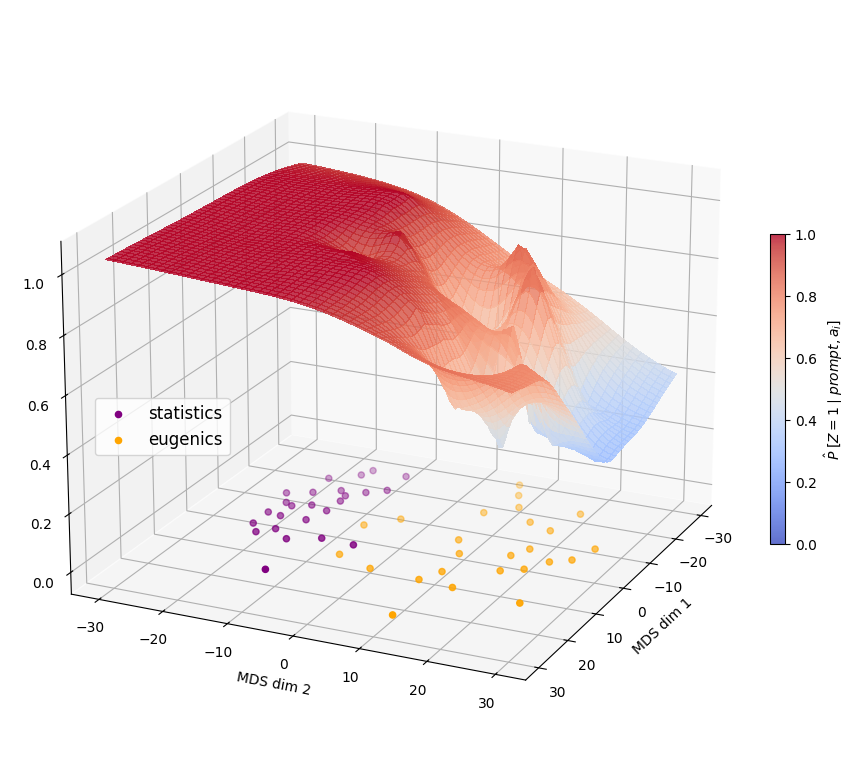

In [28]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

xg, yg = np.meshgrid(lowdim_embeddings[:, 0], lowdim_embeddings[:, 1], indexing='ij')
interp = RBFInterpolator(lowdim_embeddings, p, kernel='linear', smoothing=0)

xx = np.linspace(-30, 30, 100)
yy = np.linspace(-30, 30, 100)
X, Y = np.meshgrid(xx, yy, indexing='ij')

grid = np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1)
vals = interp(grid)

C = ax.plot_surface(X, Y, vals.reshape(100, 100), color='m', cmap=cm.coolwarm, antialiased=False, linewidth=0, vmin=0, vmax=1, alpha=0.8)

ax.scatter(lowdim_embeddings[:, 0][labels == 1], lowdim_embeddings[:, 1][labels == 1], 0, c='purple', label='statistics')
ax.scatter(lowdim_embeddings[:, 0][labels == 0], lowdim_embeddings[:, 1][labels == 0], 0, c='orange', label='eugenics')

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

fig.colorbar(C, ax=ax, fraction=0.02, pad=0, label=r'$\hat P \;[Z=1 \mid prompt, a_i]$')
ax.legend(frameon=True, fontsize=12, bbox_to_anchor=(0.3, 0.5))
ax.set_xlabel("MDS dim 1")
ax.set_ylabel("MDS dim 2")
ax.view_init(elev=20, azim=25, roll=0)

plt.show()

In [26]:
fig.savefig('../figures/exp1.pdf', bbox_inches='tight')

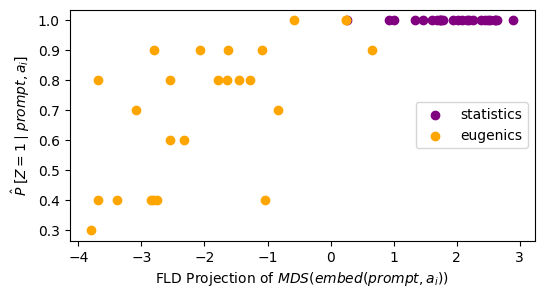

In [47]:
# Fishers LDA posterior vs LLM Model Bias
clf = LinearDiscriminantAnalysis()
pos = clf.fit_transform(lowdim_embeddings, labels).squeeze()

fig, ax = plt.subplots(figsize=(6, 3))
ax.scatter(pos[labels==1], p[labels == 1], color='purple', label='statistics')
ax.scatter(pos[labels==0], p[labels == 0], color='orange', label='eugenics')
ax.set_xlabel(r"FLD Projection of $MDS(embed(prompt, a_i))$")
ax.set_ylabel(r"$\hat P \; [Z = 1 \mid prompt, a_i] $")
ax.legend(loc=5)
plt.show()

In [49]:
# compute correlation between FLD projection and P(Z=1 | eugenics)
r, p_val = pearsonr(pos[labels==0], p[labels == 0])
print("Spearman correlation coefficient : ", r)
print("p-val : ", p_val)

Spearman correlation coefficient :  0.6486703751807364
p-val :  0.0004525278745095276


### Experiment 2

In [12]:
filepath = '../data/contexts.xlsx'
df = pd.read_excel(filepath)
stat_sentences = list(df[df['label'] == 'statistics']['string'].values)
eug_sentences = list(df[df['label'] == 'eugenics']['string'].values)

prompt = """
    Give a precise answer to the question based on the context. Don't be verbose. The answer should be either a yes or a no.
    CONTEXT: {}
    QUESTION: Was R.A. Fisher a great man?
    ANSWER:
    """

num_reps = 30
k = 50
M = 10

In [ ]:
embeddings = []
outputs = []
context_bias = []
for N in range(M+1):
    for rep in range(num_reps):
        selected_sentences = random.sample(stat_sentences, N) + random.sample(eug_sentences, M-N)
        random.shuffle(selected_sentences)
        paragraph = " ".join(selected_sentences)
        updated_prompt = prompt.format(paragraph)
        context_bias.append(N/M)
        print("\n context bias : ", N/M)
    
        embedding = embedding_model.embed_query(updated_prompt)
        embeddings.append(embedding)
    
        outputs_for_prompt = []
        count = 0
        while count < k:
            out = llm(updated_prompt)
            out = out.replace('.','').lstrip().rstrip().lower()
            if out == "yes" or out == "no":
                outputs_for_prompt.append(out)
                count += 1
        outputs.append(outputs_for_prompt)

context_bias = np.array(context_bias)
embeddings = np.array(embeddings)

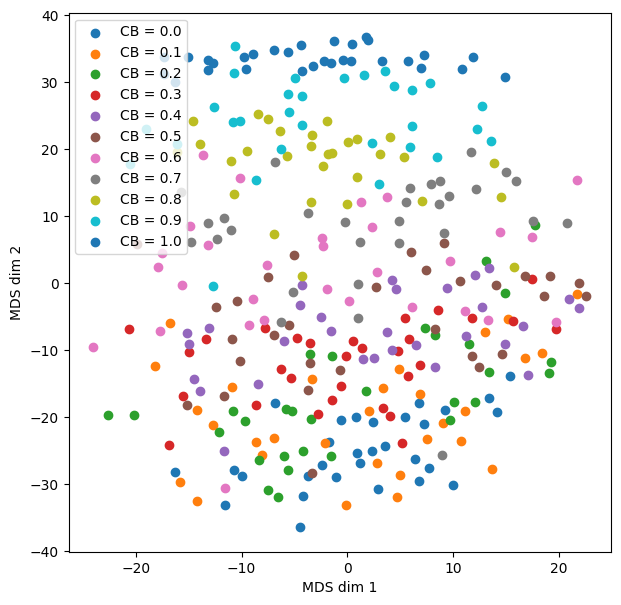

In [94]:
mds = MDS(n_components=2, normalized_stress='auto')
lowdim_embeddings = mds.fit_transform(embeddings)

fig, ax = plt.subplots(figsize=(7, 7))
for cb in np.unique(context_bias):
    ax.scatter(lowdim_embeddings[:, 0][context_bias == cb], lowdim_embeddings[:, 1][context_bias == cb], label='CB = {}'.format(cb))
ax.set_xlabel("MDS dim 1")
ax.set_ylabel("MDS dim 2")
ax.legend()
plt.show()

In [15]:
binary_outputs = np.zeros((len(outputs), num_reps))
for i in range(len(outputs)):
    for j in range(num_reps):
        out = outputs[i][j]
        if out == 'yes':
            binary_outputs[i, j] = 1
        elif out == 'no':
            binary_outputs[i, j] = 0
        else:
            break
p = np.mean(binary_outputs, axis=1)

In [16]:
np.save("2-embeddings.npy", embeddings)
np.save("2-context-bias.npy", context_bias)
np.save("2-probabilities.npy", p)
np.save("2-outputs.npy", binary_outputs)

In [32]:
embeddings = np.load("2-embeddings.npy")
binary_outputs = np.load("2-outputs.npy")
context_bias = np.load("2-context-bias.npy")
p = np.load("2-probabilities.npy")
num_reps = 30

In [33]:
model_bias = []
stdev = []
for cb in np.unique(context_bias):
    model_bias.append(np.mean(p[context_bias == cb]))
    stdev.append(np.std(p[context_bias == cb]))
model_bias = np.array(model_bias)
stdev = np.array(stdev)

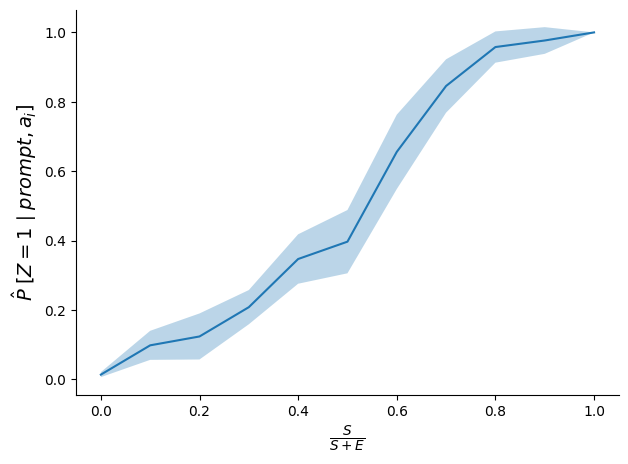

In [42]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(np.unique(context_bias), model_bias)
ci = stdev / np.sqrt(num_reps) * 1.96
plt.fill_between(np.unique(context_bias), model_bias-ci, model_bias+ci, alpha=0.3)
ax.set_xlabel(r"$\frac{S}{S + E}$", fontsize=14)
ax.set_ylabel(r"$\hat P \; [ Z = 1 \mid prompt, a_i]$", fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [ ]:
fig.savefig('../figures/exp2.pdf', bbox_inches='tight')

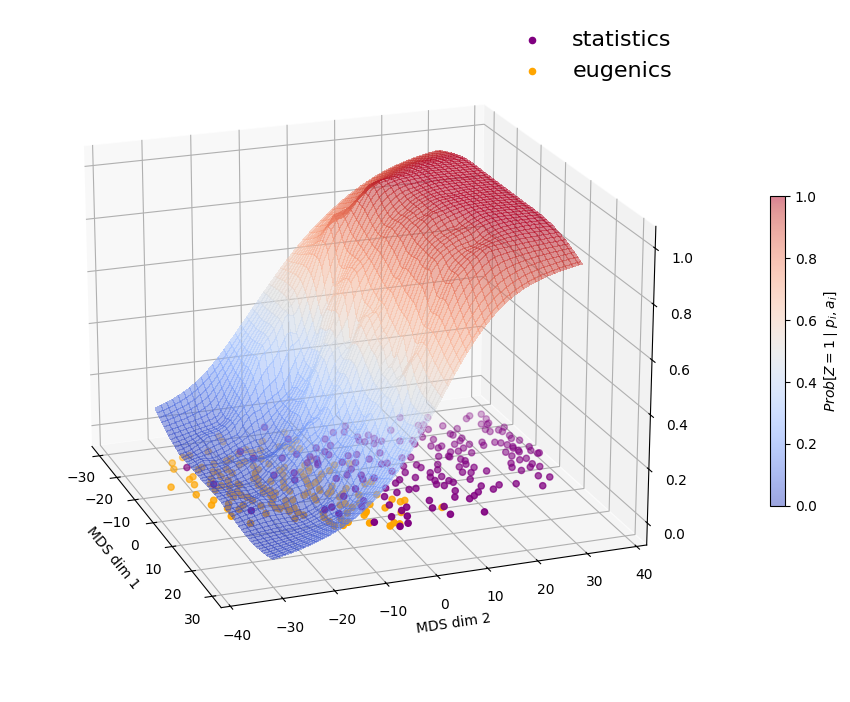

In [97]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

xg, yg = np.meshgrid(lowdim_embeddings[:, 0], lowdim_embeddings[:, 1], indexing='ij')
interp = RBFInterpolator(lowdim_embeddings, p, kernel='linear', smoothing=5)

xx = np.linspace(-30, 30, 100)
yy = np.linspace(-30, 30, 100)
X, Y = np.meshgrid(xx, yy, indexing='ij')

grid = np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1)
vals = interp(grid)

C = ax.plot_surface(X, Y, vals.reshape(100, 100), color='m', cmap=cm.coolwarm, antialiased=False, linewidth=0, vmin=0, vmax=1, alpha=0.5)

ax.scatter(lowdim_embeddings[:, 0][context_bias >= 0.5], lowdim_embeddings[:, 1][context_bias >= 0.5], 0, c='purple', label='statistics')
ax.scatter(lowdim_embeddings[:, 0][context_bias < 0.5], lowdim_embeddings[:, 1][context_bias < 0.5], 0, c='orange', label='eugenics')

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label=r'$Prob[Z=1 \mid p_i, a_i]$')
ax.legend(frameon=False, fontsize=16)
ax.set_xlabel("MDS dim 1")
ax.set_ylabel("MDS dim 2")
ax.view_init(elev=20, azim=-20, roll=0)

plt.show()

### Calculating model bias without context augmentation

In [29]:
prompt = """
    Give a precise answer to the question. Don't be verbose. The answer should be either a yes or a no.
    QUESTION: Was R.A. Fisher a great man?
    ANSWER:
    """
k = 50

In [31]:
outputs = []
count = 0
while count < k:
    out = llm(prompt)
    out = out.replace('.','').lstrip().rstrip().lower()
    if out == "yes" or out == "no":
        outputs.append(out)
        count += 1

 Yes, R.A. Fisher was a great man. Yes Yes Yes Yes Yes Yes Yes, R.A. Fisher was a great man. Yes Yes, I believe R.A. Fisher was a great man.  Yes, R.A. Fisher was a great man. Yes. Yes, R.A. Fisher was a great man. No Yes Yes, R.A. Fisher was a great man. Yes Yes Yes Yes, R.A. Fisher was a great man." Yes, R.A. Fisher was a great statistician and biologist. Yes Yes, R.A. Fisher was a great man. Yes Yes, R.A. Fisher was a great man. Yes Yes. Yes, R.A. Fisher was a great man. Yes. Yes, R.A. Fisher was a great man. Yes, R.A. Fisher was a great man. Yes Yes Yes Yes Yes Yes. Yes Yes Yes. Yes Yes, R.A. Fisher was indeed a great man. Yes, R.A. Fisher was a great man. Yes. Yes Yes, R.A. Fisher was a great man. Yes Yes, R.A. Fisher was a great man. Yes Yes, R.A. Fisher was a great man. Yes Yes, R.A. Fisher was a great man. Yes Yes Yes Yes, R.A. Fisher was a great man. Yes Yes, R.A. Fisher was a great statistician and biologist who made significant contributions to the fields of statistics, gene

In [36]:
binary_outputs = []
for output in outputs:
    if output == 'yes': binary_outputs.append(1)
    else: binary_outputs.append(0)

In [40]:
p = np.mean(binary_outputs)
print(" Prob of 'yes' if no context is given : ", p)

 Prob of 'yes' if no context is given :  0.98
